Group Members:

- Nicola Bazzani, nicola.bazzani@studenti.unipd.it, ID: 21633835

- Sara Pangrazio, sara.pangrazio@studenti.unipd.it, ID: 2165777

# Frank-Wolfe type algorithms for maximum clique problem

# 1) Description of the problem

The maxmimum clique problem is a constraint optimization problem with the goal of, given a graph $G = (V,E)$, finding the maximum clique present in the graph. A clique is defined as a subset of nodes $C \subset V$ such that $(i,j) \in E,  \forall  i,j \in C$ with $i \ne j$.

This problem can be defined as a constraint maximization problem $$ \max_{x \in \Delta} f(x), \quad \Delta = \{ x \in \mathbb{R}^n : x \ge 0 \text{ and } 1^Tx = 1\}$$ and $$f(x) = x^T A x +\frac{1}{2}x^Tx, \quad \text{where} \quad A\text{ is the adjacency matrix of G}$$.

The goal of this project is to solve the maximum clique problem of 3 different datasets, using the Frank-Wolfe algorithm and its variants. Since they are minimization algorithms, the problem becomes $$\min_{x \in \Delta}-x^T A x -\frac{1}{2}x^Tx $$. Of course, given an optimal value $f(x^*)$ of a solution $x^*$, the actual optimal value of the maximization problem will be $- f(x^*)$.

The optimal value of the solution of the maximization problem is linked to the cardinality ($\omega$) of the maximum clique found by the algorithm with this relation $$ f(x^*) = 1 - \frac{1}{2\omega}$$


# Importing Packages

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

# 1) Functions

For our minimization problem, the function $f$ and its gradient $\nabla f(x)$ are defined as $$f(x) = -x^T A x - \frac{1}{2}x^Tx = -x^T(A + \frac{1}{2}I)x, \text{  where  } I \text{  is the identity matrix},$$
$$\nabla f(x) = -2(A + \frac{1}{2}I)x = -(2A + I)x$$,

In [2]:
def function(x,A):
  n = len(A)
  I = np.eye(n)
  return - x.T @ (A + 0.5*I) @ x

In [3]:
def gradient(x,A):
  n = len(A)
  I = np.eye(n)
  return -(2*A + I) @ x

The linear minimization oracle is defined as $$LMO_C (g) = \arg \min_{x \in C} g^Tx $$
However, since we're optimizing on the simplex $$ \Delta = \{ x \in \mathbb{R}^n : x \ge 0 \text{ and } e^Tx = 1\}, \quad e = (1 \dots 1) ,$$ we have that $$LMO_\Delta (\nabla f(x_k)) = e_{i_k}, \quad i_k = \arg \min_i \nabla_i f(x_k)$$

In [4]:
def LMO_simplex(g,x_k,A):
  # D = {x in R^n | x_i >= 0, e.T @ x = 1}
  n = len(A)
  e = np.zeros(n)
  i = np.argmin(g(x_k,A))
  e[i] = 1
  return e

Exact line search is one of the line-search methods we will use in our algorithms. At each iteration, given the descent direction $d_k$, the stepsize $\gamma_k^*$ is such that $$\gamma_k^* = \arg \min_{\gamma \in [0, \gamma_{max}]} f(x_k + d_k \gamma_k)$$

In [5]:
# grid version of exact line search
def exact_line_search(f, x, d, A, gamma_max, steps=20):
  best_gamma = 0.0
  best_value = f(x, A)
  # make grid of f(x + alpha*d, A) values to choose the best one
  for i in range(1, steps + 1):
      gamma = gamma_max * i / steps
      fx = f(x + gamma*d, A)

      if fx < best_value:
          best_value = fx
          best_gamma = gamma

  return best_gamma

The duality gap is needed for the stopping criterion and is defined as $$ gap(x) = \max_{s \in C} \langle \nabla f(x) , x - s \rangle$$
The algorithms stop when $gap(x) \le \epsilon$, so, when $$\langle \nabla f(x) , x - s \rangle \le \epsilon $$

In [6]:
def duality_gap(x, gradient, s):
   return np.dot(gradient, x - s)

# 2) Algorithms: Frank-Wolfe, Away Steps Frank-Wolfe, Pairwise Frank-Wolfe

- Classic Frank-Wolfe algorithm. The descent direction $d^{FW}$ is the direction given by the $LMO$.

In [7]:
def Frank_Wolfe(f,g, A, x0,LMO, checkpoints, max_it, eps = 1e-2):
  """
  inputs:
  f: objective function
  g: objective function's gradient
  x0: initial vector
  LMO: Linear Minimization Oracle (LMO(g) = argmin g.T @ z )
                                            (z in D)
  checkpoints: list containing the iterations where the algorithm saves the solutions and optimal values
  max_it: max iteration
  eps: stopping tolerance

  """

  x = x0.copy()
  f0 = f(x0,A)
  it = 0
  stop_cr = 1
  start_time = time.time()
  checkpoint_fx = {}  # dictionary to put the values of y for every iteration in checkpoint
  checkpoint_fx[0] = [f0,x0.copy()]

  while (it < max_it) and (stop_cr == 1):

    f_k = f(x, A)
    g_k = g(x, A)

    s = LMO(g,x, A)

    # implementing duality gap as stopping criterion
    gap = duality_gap(x, g_k, s)
    if gap < eps:
      stop_cr = 0
      break

    d = s - x

    # diminishing line search
    alpha = 2/(it + 1)

    x += alpha*d
    fx = f(x, A)
    it +=1
    if (it in checkpoints):     # if it is a significant iteration, se save the result y
            checkpoint_fx[it] = [fx, x.copy()]

  checkpoint_fx[it] = [fx,x.copy()]
  ttot = time.time() - start_time
  return x, it, fx, checkpoint_fx, ttot

- Frank Wolfe Away Steps. There are two descent directions, one (classic $d^{FW}$) given by the $LMO$ and one new Away direction ($d^{AW}$), introduced to move away from the vertices on the simplex. We choose the direction $d_k$ that maximizes the value $\langle \nabla f(x_k), d_k \rangle$.

In [8]:
def FWAS(f, g, A, x0, LMO, checkpoints, arls, max_it, eps=1e-5):
    """
    inputs:
    f: objective function
    g: objective function's gradient
    x0: initial vector
    LMO: Linear Minimization Oracle (LMO(g) = argmin g.T @ z )
                                              (z in D)
    checkpoints: list containing the iterations where the algorithm saves the solutions and optimal values
    arls: selects line-search method (1 = Exact Line Search, 2 = Armijo Rule, 3 = Diminishing)
    max_it: max iteration
    eps: stopping tolerance

    """
    x = x0.copy()
    it = 0
    stop_cr = 1
    start_time = time.time()
    f0 = f(x0,A)
    checkpoint_fx = {}  # dictionary to put the values of y for every iteration in checkpoint
    checkpoint_fx[0] = [f0,x0.copy()]
    n = len(A)

    # Initialize active set
    active_indices = np.where(x0 > 1e-10)[0]
    active_weights = x0[active_indices]
    S = [np.eye(n)[idx] for idx in active_indices]

    while (it < max_it) and (stop_cr == 1):
        f_k = f(x, A)
        g_k = g(x, A)


        # Frank-Wolfe direction
        s_FW = LMO(g, x, A)
        gap = duality_gap(x, g_k, s_FW)
        d_FW = s_FW - x
        g_FW = -g_k @ d_FW

        # # Away direction selection
        if len(active_indices) == 0:
            break

        # Get gradient values at active vertices
        active_gradients = g_k[active_indices]

        # Find which active vertex has maximum gradient (internal index)
        internal_away_idx = np.argmax(active_gradients)
        away_vertex_original_idx = active_indices[internal_away_idx]
        s_AS = S[internal_away_idx]
        d_AS = x - s_AS
        g_AS = -g_k @ d_AS

        # Choose direction
        if g_FW >= g_AS:
            direction = d_FW
            gamma_max = 1.0
            step_type = 'FW'
        else:
            direction = d_AS
            gamma_max = active_weights[internal_away_idx] / (1 - active_weights[internal_away_idx] + 1e-12)
            step_type = 'AS'

        # stopping criterion
        if gap < eps:
            stop_cr = 0
            break

       # Line search
        if arls == 1:
            gamma = exact_line_search(f, x, direction, A, gamma_max)
        elif arls == 2:
            delta = 0.5
            eta = 1e-4
            gamma = min(gamma_max, 1.0)
            while f(x + gamma * direction, A) > f_k + eta * gamma * np.dot(g_k.T,direction):
                gamma *= delta
        elif arls == 3:
            gamma = 2 / (it + 1)

        # Update x
        x = x + gamma * direction

        # Update active set
        # FW direction
        if step_type == 'FW':
            if gamma == 1.0:  # Drop step
                active_indices = np.array([np.argmax(s_FW)])
                active_weights = np.array([1.0])
                S = [s_FW]
            else:
                active_weights *= (1 - gamma)
                new_FW_idx = np.argmax(s_FW)
                if new_FW_idx in active_indices:
                    existing_idx = np.where(active_indices == new_FW_idx)[0][0]
                    active_weights[existing_idx] += gamma
                else:
                    active_indices = np.append(active_indices, new_FW_idx)
                    active_weights = np.append(active_weights, gamma)
                    S.append(np.eye(n)[new_FW_idx])
        # away direction
        else:
            if np.isclose(gamma, gamma_max):  # Drop step
                # Remove away vertex
                active_weights = np.delete(active_weights, internal_away_idx)
                active_indices = np.delete(active_indices, internal_away_idx)
                del S[internal_away_idx]
                active_weights *= (1 + gamma)
            else:
                active_weights *= (1 + gamma)
                active_weights[internal_away_idx] -= gamma

        # Ensure numerical stability
        x[x < 1e-10] = 0    # Prune near-zero weights
        x /= x.sum()       # project back on the simplex
        fx = f(x,A)
        it += 1

        if it in checkpoints:
            checkpoint_fx[it] = [fx,x.copy()]

    checkpoint_fx[it] = [fx,x.copy()]
    ttot = time.time() - start_time
    return x, it, f_k, checkpoint_fx, ttot

- Pairwise Frank Wolfe: both $FW$ and $AS$ descent directions are calculated, and we choose the pairwise direction $d^{PFW} = d^{FW} + d^{AS}$, to move toward the $FW$ atom.

In [9]:
def PFW(f, g, A, x0, LMO, checkpoints, arls, max_it, eps=1e-5):
    """
    inputs:
    f: objective function
    g: objective function's gradient
    x0: initial vector
    LMO: Linear Minimization Oracle (LMO(g) = argmin g.T @ z )
                                              (z in D)
    checkpoints: list containing the iterations where the algorithm saves the solutions and optimal values
    arls: selects line-search method (1 = Exact Line Search, 2 = Armijo Rule, 3 = Diminishing)
    max_it: max iteration
    eps: stopping tolerance

    """
    x = x0.copy()
    it = 0
    stop_cr = 1
    start_time = time.time()
    f0 = f(x0,A)
    checkpoint_fx = {}  # dictionary to put the values of y for every iteration in checkpoint
    checkpoint_fx[0] = [f0,x0.copy()]
    n = len(A)

    # Initialize active set
    active_indices = np.where(x0 > 1e-10)[0]  # Original vertex indices
    active_weights = x0[active_indices]       # Their weights
    S = [np.eye(n)[idx] for idx in active_indices]

    while (it < max_it) and (stop_cr == 1):
        f_k = f(x, A)
        g_k = g(x, A)

        # FW direction
        s_FW = LMO(g, x, A)
        gap = duality_gap(x, g_k, s_FW)
        d_FW = s_FW - x

        # Away direction selection

        if len(active_indices) == 0:
            break

        # Get gradient values at active vertices
        active_gradients = g_k[active_indices]

        # Find which active vertex has maximum gradient (internal index)
        internal_away_idx = np.argmax(active_gradients)
        away_vertex_original_idx = active_indices[internal_away_idx]
        s_AS = S[internal_away_idx]

        # Pairwise direction
        d_PFW = s_FW - s_AS
        gamma_max = active_weights[internal_away_idx]

        # Stopping criterion
        if gap < eps:
            stop_cr = 0
            break

        # Line search
        if arls == 1:
            gamma = exact_line_search(f, x, d_PFW, A, gamma_max)
        elif arls == 2:
            delta, eta = 0.5, 1e-4
            gamma = min(1.0, gamma_max)
            while f(x + gamma * d_PFW, A) > f_k + eta * gamma * (g_k.T @ d_PFW):
                gamma *= delta
        elif arls == 3:
            gamma = 2/(it + 1)

        # UPDATE ACTIVE SET
        # 1. Decrease away vertex weight
        active_weights[internal_away_idx] -= gamma

        # 2. Find new FW vertex
        new_FW_original_idx = np.argmax(s_FW)

        # 3. Remove away vertex if weight ~0
        if active_weights[internal_away_idx] < 1e-10:
            active_weights = np.delete(active_weights, internal_away_idx)
            active_indices = np.delete(active_indices, internal_away_idx)
            del S[internal_away_idx]

        # 4. Add/increase FW vertex weight
        if new_FW_original_idx in active_indices:
            existing_idx = np.where(active_indices == new_FW_original_idx)[0][0]
            active_weights[existing_idx] += gamma

        else:
            active_indices = np.append(active_indices, new_FW_original_idx)
            active_weights = np.append(active_weights, gamma)
            S.append(np.eye(n)[new_FW_original_idx])

        # Direct Update
        x = x + gamma * d_PFW

        # Ensure numerical stability
        x[x < 1e-10] = 0  # Prune near-zero weights
        x /= x.sum()      # Project back on the simplex
        fx = f(x,A)
        it += 1
        if it in checkpoints:
            checkpoint_fx[it] = [fx,x.copy()]

    checkpoint_fx[it] = [fx,x.copy()]
    ttot = time.time() - start_time
    return x, it, f_k, checkpoint_fx, ttot

# 2) The Datasets

We considered three datasets from three different families of the DIMACS benchmark.
- From the p_hat family we chose the dataset **p_hat300-3**, a graph with 300 nodes, 33390 edges and $\omega(G) = 36$.

- From the C family, we chose the dataset **C125.9**, a graph with 125 nodes, 6963 edges and $\omega(G) = 34$.

- From the Hamming family, we chose the dataset **hamming8-4**, a graph with 256 nodes, , 20864 edges and $\omega(G) = 16$.

We loaded the files and extracted the adjacency matrices, naming them, respectivly, P, C, H. We then plotted each graph.

In [10]:
#### File p_hat300-3 ###

file_path = "p_hat300-3.clq"
nodes = 0
edges = []

# Find the number of nodes
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('p'):
            parts = line.split()
            nodes = int(parts[2])
            break

# Initialize adjacency matrix
P = np.zeros((nodes, nodes), dtype=int)

# Fill the matrix
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('e'):
            u, v = map(int, line.split()[1:3])
            P[u-1][v-1] = 1  # DIMACS uses 1-based indexing
            P[v-1][u-1] = 1  # Undirected graph (symmetric)


print("Matrix P has shape: ",P.shape)


### file C125.9 ###

file_path = "C125.9.clq"
nodes = 0
edges = []

# Find the number of nodes
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('p'):
            parts = line.split()
            nodes = int(parts[2])
            break

# Initialize adjacency matrix
C = np.zeros((nodes, nodes), dtype=int)

# Fill the matrix
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('e'):
            u, v = map(int, line.split()[1:3])
            C[u-1][v-1] = 1  # DIMACS uses 1-based indexing
            C[v-1][u-1] = 1  # Undirected graph (symmetric)


print("Matrix C has shape: ",C.shape)

### file hamming-8.4 ###

file_path = "hamming8-4.clq"
nodes = 0
edges = []

# Find the number of nodes
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('p'):
            parts = line.split()
            nodes = int(parts[2])
            break

# Initialize adjacency matrix
H = np.zeros((nodes, nodes), dtype=int)

#  Fill the matrix
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('e'):
            u, v = map(int, line.split()[1:3])
            H[u-1][v-1] = 1  # DIMACS uses 1-based indexing
            H[v-1][u-1] = 1  # Undirected graph (symmetric)

print("Matrix H has shape: ",H.shape)



Matrix P has shape:  (300, 300)
Matrix C has shape:  (125, 125)
Matrix H has shape:  (256, 256)


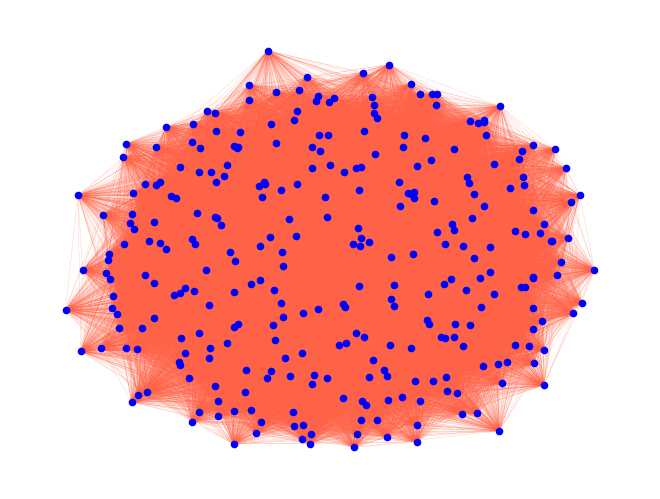

In [ ]:
G = nx.from_numpy_array(P)

# Draw the graph
nx.draw(G, node_color='blue', edge_color='tomato', width = 0.1, node_size=20)
plt.show()

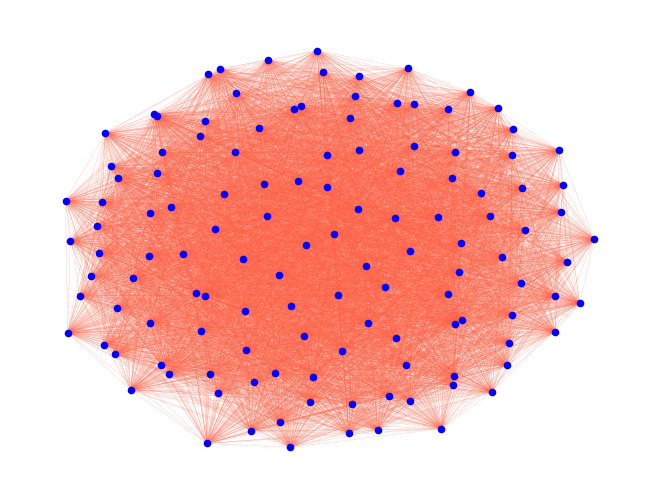

In [ ]:
G = nx.from_numpy_array(C)

# Draw the graph
nx.draw(G, node_color='blue', edge_color='tomato', width = 0.1, node_size=20)
plt.show()

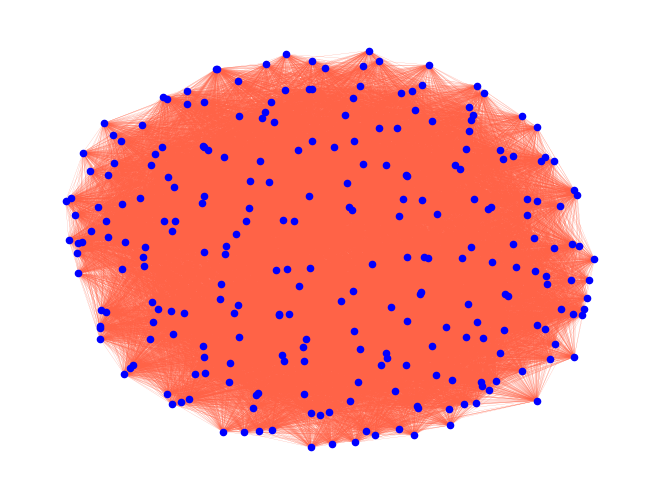

In [ ]:
G = nx.from_numpy_array(H)

# Draw the graph
nx.draw(G, node_color='blue', edge_color='tomato', width = 0.1, node_size=20)
plt.show()

# 3) Testing the Algorithms

We defined our starting points on the simplex and put a seed for results consistency. We computed the `checkpoints` list to be more dense in the first iterations and sparse in the last iterations, since most of the flactuations of the results happened whithin the first 100  iterations.

In [37]:
# define starting points
np.random.seed(42)

x_p= np.random.rand(300)
x_p /= x_p.sum()

x_c= np.random.rand(125)
x_c /= x_c.sum()

x_h= np.random.rand(256)
x_h /= x_h.sum()



checkpoints = list(range(0, 101, 10)) +  list(range(120, 301, 20)) + list(range(350, 801, 50))

The function `clique_accuracy`
takes as input one of the algorithms and tests it on every dataset, to see if the clique found by the algorithm has the same cardinality of the True Maximum Clique. It plots the results and returns a dictionary we will use later.

We calculated the estimated cardinality of the clique found by the algorithm using the optimal value: $$f(x) = 1 - \frac{1}{2\omega} \Longrightarrow \omega = \frac{1}{2(1 - f(x))}$$

 We tested the FWAS and PFW algorithms with the Armijo line-search, since it was the one that got the best results.

In [38]:
def clique_accuracy(algorithm, x_p, x_c, x_h, checkpoints, maxit, arls=0, plot = "Yes"):

    w_p = 36
    w_c = 34
    w_h = 16

    if algorithm == Frank_Wolfe:
        _, it_p, _, dic_p, ttot_p = algorithm(function, gradient, P, x_p, LMO_simplex, checkpoints, maxit)
        _, it_c, _, dic_c, ttot_c = algorithm(function, gradient, C, x_c, LMO_simplex, checkpoints, maxit)
        _, it_h, _, dic_h, ttot_h = algorithm(function, gradient, H, x_h, LMO_simplex, checkpoints, maxit)
    else:
        _, it_p, _, dic_p, ttot_p = algorithm(function, gradient, P, x_p, LMO_simplex, checkpoints, max_it=maxit, arls=arls)
        _, it_c, _, dic_c, ttot_c = algorithm(function, gradient, C, x_c, LMO_simplex, checkpoints, max_it=maxit, arls=arls)
        _, it_h, _, dic_h, ttot_h = algorithm(function, gradient, H, x_h, LMO_simplex, checkpoints, max_it=maxit, arls=arls)

    threshold_p = 0
    threshold_c = 0
    threshold_h = 0

    # Get the actual checkpoints used for each dataset
    checkpoints_p = list(dic_p.keys())[1:]
    checkpoints_c = list(dic_c.keys())[1:]
    checkpoints_h = list(dic_h.keys())[1:]

    fx_p = np.array([-dic_p[it][0]  for it in checkpoints_p])
    card_p = np.round(1/(2*(1-fx_p)))
    card_p = np.array([int(i) for i in card_p])


    fx_c = np.array([-dic_c[it][0]  for it in checkpoints_c])
    card_c = np.round(1/(2*(1-fx_c)))
    card_c = np.array([int(i) for i in card_c])

    fx_h = np.array([-dic_h[it][0]  for it in checkpoints_h])
    card_h = np.round(1/(2*(1-fx_h)))
    card_h = np.array([int(i) for i in card_h])


    err_p = w_p - card_p
    err_c = w_c - card_c
    err_h = w_h - card_h

    # PLOT
    if plot == "Yes":
        plt.figure(figsize=(10, 6))

        plt.plot(checkpoints_p, err_p[:len(checkpoints_p)], '*-', color='green', label='P', markersize=6)
        plt.plot(checkpoints_c, err_c[:len(checkpoints_c)], '*-', color='blue', label='C', markersize=6)
        plt.plot(checkpoints_h, err_h[:len(checkpoints_h)], '*-', color='red', label='H', markersize=6)

        # Total time
        time_text = f"Total time:\nP = {ttot_p:.2f}s\nC = {ttot_c:.2f}s\nH = {ttot_h:.2f}s"
        plt.gcf().text(0.1, 0.15, time_text, fontsize=11, color='black',
                      bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


        plt.ylim(auto=True)

        # Labels
        plt.xlabel('Iterations', fontsize=12)
        plt.ylabel("Maximum clique's cardinality error", fontsize=12)
        plt.title(f"Maximum clique's cardinality convergence rate ({algorithm.__name__})", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

    results = {"Error array": [err_p, err_c, err_h],  "Clique size arrays" : [card_p, card_c, card_h], "Total time Arrays":  [ttot_p, ttot_c, ttot_h] }

    return results

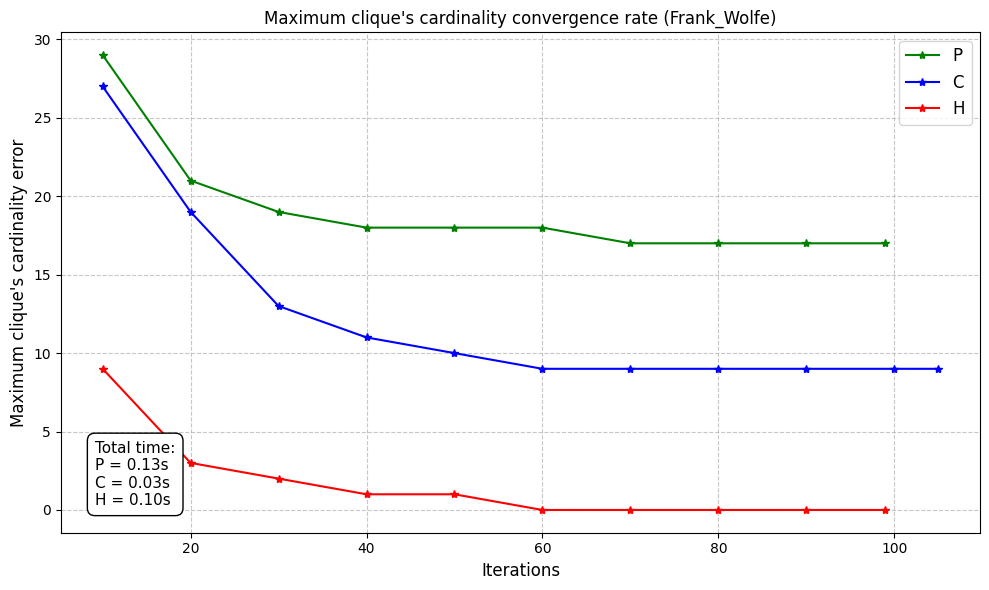

{'Error array': [array([29, 21, 19, 18, 18, 18, 17, 17, 17, 17]),
  array([27, 19, 13, 11, 10,  9,  9,  9,  9,  9,  9]),
  array([9, 3, 2, 1, 1, 0, 0, 0, 0, 0])],
 'Clique size arrays': [array([ 7, 15, 17, 18, 18, 18, 19, 19, 19, 19]),
  array([ 7, 15, 21, 23, 24, 25, 25, 25, 25, 25, 25]),
  array([ 7, 13, 14, 15, 15, 16, 16, 16, 16, 16])],
 'Total time Arrays': [0.130784273147583,
  0.02888941764831543,
  0.0993797779083252]}

In [39]:
clique_accuracy(Frank_Wolfe,x_p, x_c, x_h,checkpoints, 800)

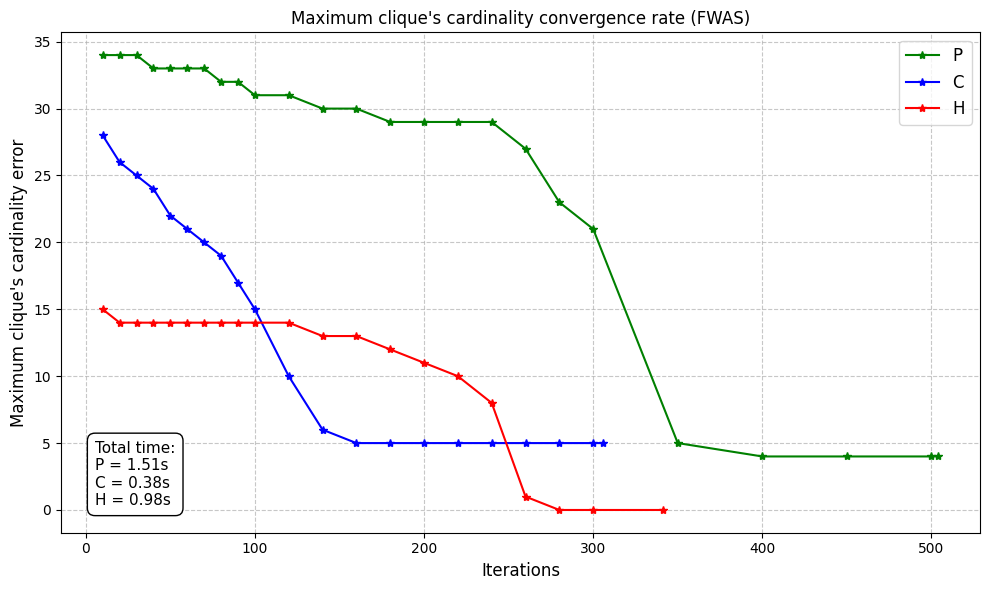

{'Error array': [array([34, 34, 34, 33, 33, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 29, 29,
         27, 23, 21,  5,  4,  4,  4,  4]),
  array([28, 26, 25, 24, 22, 21, 20, 19, 17, 15, 10,  6,  5,  5,  5,  5,  5,
          5,  5,  5,  5]),
  array([15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 12, 11, 10,  8,
          1,  0,  0,  0])],
 'Clique size arrays': [array([ 2,  2,  2,  3,  3,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,  7,
          9, 13, 15, 31, 32, 32, 32, 32]),
  array([ 6,  8,  9, 10, 12, 13, 14, 15, 17, 19, 24, 28, 29, 29, 29, 29, 29,
         29, 29, 29, 29]),
  array([ 1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  4,  5,  6,  8,
         15, 16, 16, 16])],
 'Total time Arrays': [1.509826421737671,
  0.3753376007080078,
  0.9808268547058105]}

In [40]:
clique_accuracy(FWAS, x_p, x_c, x_h, checkpoints, 800, arls=2, plot = "Yes")

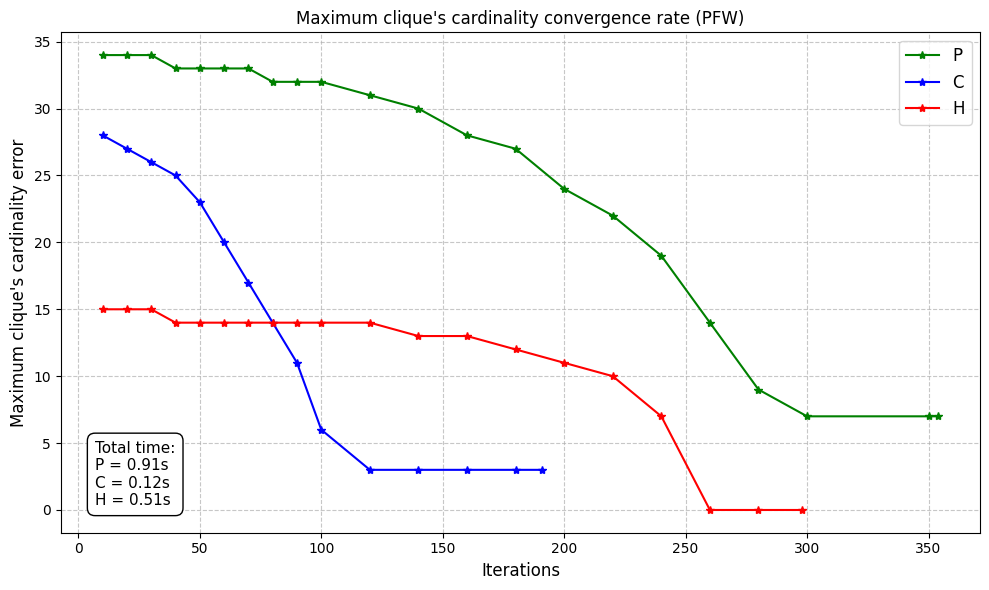

{'Error array': [array([34, 34, 34, 33, 33, 33, 33, 32, 32, 32, 31, 30, 28, 27, 24, 22, 19,
         14,  9,  7,  7,  7]),
  array([28, 27, 26, 25, 23, 20, 17, 14, 11,  6,  3,  3,  3,  3,  3]),
  array([15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 12, 11, 10,  7,
          0,  0,  0])],
 'Clique size arrays': [array([ 2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  5,  6,  8,  9, 12, 14, 17,
         22, 27, 29, 29, 29]),
  array([ 6,  7,  8,  9, 11, 14, 17, 20, 23, 28, 31, 31, 31, 31, 31]),
  array([ 1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  4,  5,  6,  9,
         16, 16, 16])],
 'Total time Arrays': [0.9096503257751465,
  0.12035298347473145,
  0.5101203918457031]}

In [41]:
clique_accuracy(PFW,x_p, x_c, x_h,checkpoints, 800, arls=2)

The function `compare_algorithms_on_dataset` takes as input a dataset and tests each of the algorithms on it, to see which one performed best.

In [43]:
def compare_algorithms_on_dataset(dataset_name, x, checkpoints, maxit): # Funzione che sullo stesso dataset compare i tre algoritmi e mostra anche un label con error e time
    # Dataset setup
    if dataset_name == "P":
        dataset_name = "p_hat300-3"
        A = P
        w = 36
        color = 'green'
    elif dataset_name == "C":
        dataset_name = "C125.9"
        A = C
        w = 34
        color = 'blue'
    elif dataset_name == "H":
        dataset_name = "hamming8-4"
        A = H
        w = 16
        color = 'red'
    else:
        raise ValueError("Dataset must be one of: 'P', 'C', 'H'")

    threshold = 0
    results = {}

    for alg_name, alg_fn in [("Frank-Wolfe", Frank_Wolfe),
                             ("Away-step", FWAS),
                             ("Stepwise step", PFW)]:
        if alg_name == "Frank-Wolfe":
            _, _, _, dic, ttot = alg_fn(function, gradient, A, x, LMO_simplex, checkpoints, maxit)
        else:
            _, _, _, dic, ttot = alg_fn(function, gradient, A, x, LMO_simplex, checkpoints, max_it=maxit, arls=2)

        checkpoint_keys = list(dic.keys())[1:]
        fx = [-dic[it][0]  for it in checkpoint_keys]
        fx = np.asarray(fx)
        card_p = np.round(1/(2*(1-fx)))
        errors = w - card_p
        clique_sizes = card_p

        results[alg_name] = {
            'errors': errors,
            'sizes': clique_sizes,
            'ttot': ttot,
            'iters': list(dic.keys())[1:]
        }

    # PLOT
    plt.figure(figsize=(10, 6))

    for alg_name, style, col in zip(["Frank-Wolfe", "Away-step", "Stepwise step"],
                                    ['o-', '*-', 'x-'],
                                    ['black', 'orange', 'purple']):
        plt.plot(results[alg_name]['iters'], results[alg_name]['errors'],
                 style, label=alg_name, color=col, markersize=6)

    # Time + Final Error Box
    summary_text = ""
    for alg_name in results:
        ttot = results[alg_name]['ttot']
        final_err = results[alg_name]['errors'][-1]
        summary_text += f"{alg_name}: time = {ttot:.2f}s, final err = {int(final_err)}\n"

    plt.gcf().text(0.1, 0.75, summary_text.strip(), fontsize=11, color='black',
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


    # Y-axis scaling
    # Y-axis scaling: fixed range
    plt.ylim(-5, 50)

    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel("Maximum clique's cardinality error", fontsize=12)
    plt.title(f"Comparison of algorithms on dataset {dataset_name}", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


    return  results

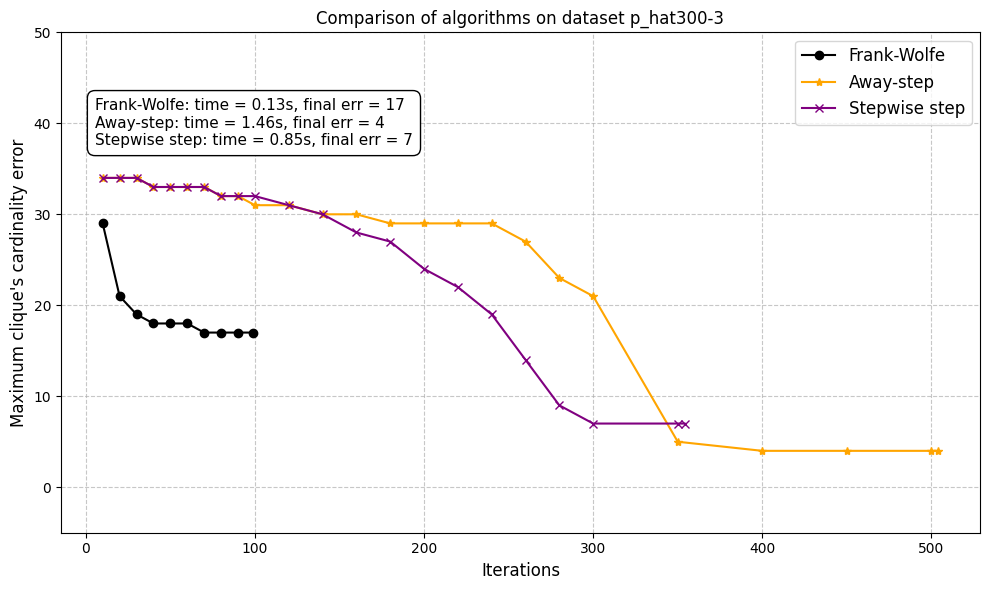

{'Frank-Wolfe': {'errors': array([29., 21., 19., 18., 18., 18., 17., 17., 17., 17.]),
  'sizes': array([ 7., 15., 17., 18., 18., 18., 19., 19., 19., 19.]),
  'ttot': 0.1302337646484375,
  'iters': [10, 20, 30, 40, 50, 60, 70, 80, 90, 99]},
 'Away-step': {'errors': array([34., 34., 34., 33., 33., 33., 33., 32., 32., 31., 31., 30., 30.,
         29., 29., 29., 29., 27., 23., 21.,  5.,  4.,  4.,  4.,  4.]),
  'sizes': array([ 2.,  2.,  2.,  3.,  3.,  3.,  3.,  4.,  4.,  5.,  5.,  6.,  6.,
          7.,  7.,  7.,  7.,  9., 13., 15., 31., 32., 32., 32., 32.]),
  'ttot': 1.4606432914733887,
  'iters': [10,
   20,
   30,
   40,
   50,
   60,
   70,
   80,
   90,
   100,
   120,
   140,
   160,
   180,
   200,
   220,
   240,
   260,
   280,
   300,
   350,
   400,
   450,
   500,
   504]},
 'Stepwise step': {'errors': array([34., 34., 34., 33., 33., 33., 33., 32., 32., 32., 31., 30., 28.,
         27., 24., 22., 19., 14.,  9.,  7.,  7.,  7.]),
  'sizes': array([ 2.,  2.,  2.,  3.,  3.,  3.,  

In [44]:
compare_algorithms_on_dataset("P", x_p, checkpoints, maxit=800)

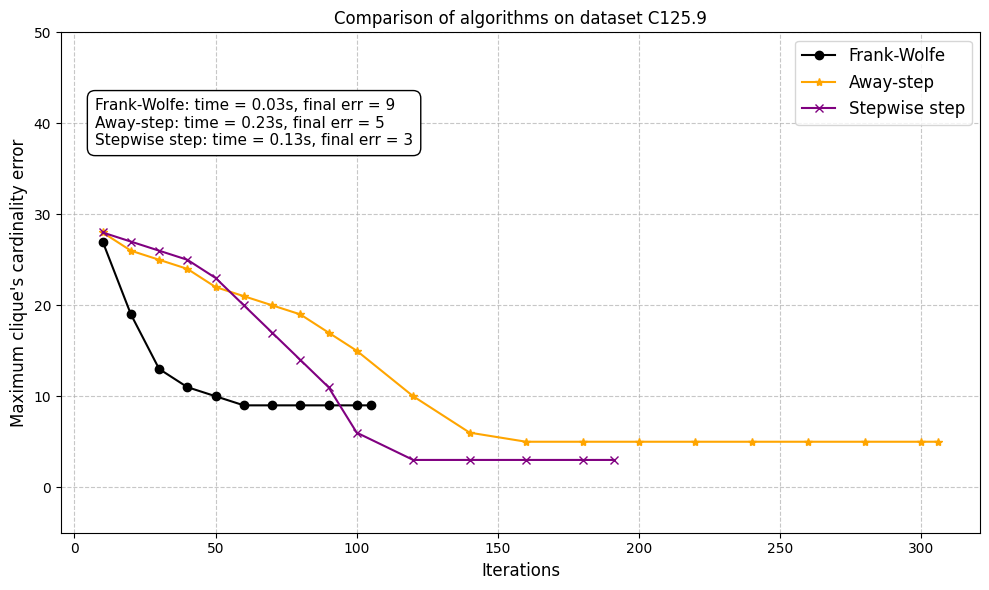

{'Frank-Wolfe': {'errors': array([27., 19., 13., 11., 10.,  9.,  9.,  9.,  9.,  9.,  9.]),
  'sizes': array([ 7., 15., 21., 23., 24., 25., 25., 25., 25., 25., 25.]),
  'ttot': 0.026956796646118164,
  'iters': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 105]},
 'Away-step': {'errors': array([28., 26., 25., 24., 22., 21., 20., 19., 17., 15., 10.,  6.,  5.,
          5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.]),
  'sizes': array([ 6.,  8.,  9., 10., 12., 13., 14., 15., 17., 19., 24., 28., 29.,
         29., 29., 29., 29., 29., 29., 29., 29.]),
  'ttot': 0.23219752311706543,
  'iters': [10,
   20,
   30,
   40,
   50,
   60,
   70,
   80,
   90,
   100,
   120,
   140,
   160,
   180,
   200,
   220,
   240,
   260,
   280,
   300,
   306]},
 'Stepwise step': {'errors': array([28., 27., 26., 25., 23., 20., 17., 14., 11.,  6.,  3.,  3.,  3.,
          3.,  3.]),
  'sizes': array([ 6.,  7.,  8.,  9., 11., 14., 17., 20., 23., 28., 31., 31., 31.,
         31., 31.]),
  'ttot': 0.13444757461547852,
  

In [45]:
compare_algorithms_on_dataset("C", x_c, checkpoints, maxit=800)

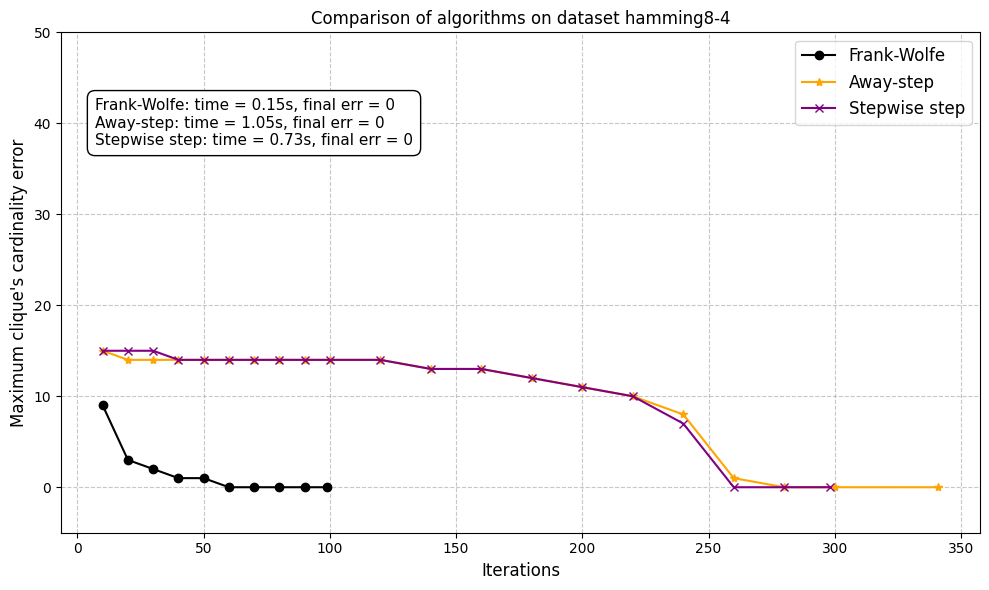

{'Frank-Wolfe': {'errors': array([9., 3., 2., 1., 1., 0., 0., 0., 0., 0.]),
  'sizes': array([ 7., 13., 14., 15., 15., 16., 16., 16., 16., 16.]),
  'ttot': 0.15018367767333984,
  'iters': [10, 20, 30, 40, 50, 60, 70, 80, 90, 99]},
 'Away-step': {'errors': array([15., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 13., 13.,
         12., 11., 10.,  8.,  1.,  0.,  0.,  0.]),
  'sizes': array([ 1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,
          4.,  5.,  6.,  8., 15., 16., 16., 16.]),
  'ttot': 1.0462243556976318,
  'iters': [10,
   20,
   30,
   40,
   50,
   60,
   70,
   80,
   90,
   100,
   120,
   140,
   160,
   180,
   200,
   220,
   240,
   260,
   280,
   300,
   341]},
 'Stepwise step': {'errors': array([15., 15., 15., 14., 14., 14., 14., 14., 14., 14., 14., 13., 13.,
         12., 11., 10.,  7.,  0.,  0.,  0.]),
  'sizes': array([ 1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,
          4.,  5.,  6.,  9., 16., 16., 16.]),
  'ttot': 0

In [46]:
compare_algorithms_on_dataset("H", x_h, checkpoints, maxit=800)

The function `is_clique` verifies that the nodes identified by the algorithm actually belong to a clique, so if they have the following property $$ (i,j) \in E,  \forall  i,j \in C \quad \text{with} \quad  i \ne j$$ The nodes identified are represented by the indices in the resulting solution vector that are significantly different than 0.



In [50]:
def is_clique(algorithm,x_p, x_c, x_h, maxit, arls=0, plot = "No"):

  checkpoints = [10,20,50,100,150,200,250,300,400,600,700,800]
  if algorithm == Frank_Wolfe:
     x,_,_,_,_ = algorithm(function, gradient,P, x_p, LMO_simplex, checkpoints,maxit)
     y,_,_,_,_ = algorithm(function, gradient,C, x_c, LMO_simplex, checkpoints,maxit)
     z,_,_,_,_ = algorithm(function, gradient, H, x_h, LMO_simplex, checkpoints ,maxit)

  else:
     x,_,_,_,_  = algorithm(function, gradient, P, x_p, LMO_simplex, checkpoints , max_it = maxit, arls = arls)
     y,_,_,_,_  = algorithm(function, gradient, C, x_c, LMO_simplex, checkpoints , max_it = maxit, arls = arls)
     z,_,_,_,_  = algorithm(function, gradient, H, x_h, LMO_simplex, checkpoints , max_it = maxit, arls = arls)

  threshold_p = 0
  threshold_c = 0
  threshold_h = 0

  indices_p = []
  for i in range(len(x)):
    if x[i] > threshold_p:
      indices_p.append(i)
  n_p = len(indices_p)

  indices_c = []
  for i in range(len(y)):
    if y[i] > threshold_c:
      indices_c.append(i)
  n_c = len(indices_c)

  indices_h = []
  for i in range(len(z)):
    if z[i] > threshold_h:
      indices_h.append(i)
  n_h = len(indices_h)

  if plot == "Yes":
    clique_P = P[indices_p][:, indices_p]
    clique_C = C[indices_c][:, indices_c]
    clique_H = H[indices_h][:, indices_h]

    G1 = nx.from_numpy_array(clique_P)

    nx.draw(G1, node_color='blue', edge_color='tomato', width = 1, node_size=20)
    plt.title(f"Clique returned by algorithm {algorithm.__name__} on dataset p_hat300-3")
    plt.show()

    G2 = nx.from_numpy_array(clique_C)

    nx.draw(G2, node_color='blue', edge_color='tomato', width = 1, node_size=20)
    plt.title(f"Clique returned by algorithm {algorithm.__name__} on dataset C125.9")
    plt.show()

    G3 = nx.from_numpy_array(clique_H)

    nx.draw(G3, node_color='blue', edge_color='tomato', width = 1, node_size=20)
    plt.title(f"Clique returned by algorithm {algorithm.__name__} on dataset hamming8-4")
    plt.show()

  missing_edges_p = []
  missing_edges_c = []
  missing_edges_h = []

  for i in range(n_p):
      for j in range(i+1, n_p):
        if i != j:
          node_i = indices_p[i]
          node_j = indices_p[j]
          if P[node_i , node_j] == 0:
              missing_edges_p.append((node_i, node_j))

  for i in range(n_c):
      for j in range(i+1, n_c):
        if i != j:
          node_i = indices_c[i]
          node_j = indices_c[j]
          if C[node_i , node_j] == 0:
              missing_edges_c.append((node_i, node_j))


  for i in range(n_h):
      for j in range(i+1, n_h):
        if i != j:
          node_i = indices_h[i]
          node_j = indices_h[j]
          if H[node_i , node_j] == 0:
              missing_edges_h.append((node_i, node_j))

  results = []

  if len(missing_edges_p) == 0:
      print("Dataset p_hat300-3: the given indices form a clique.")
      results.append(True)
  else:
      print("Dataset p_hat300-3: the given indices do not form a clique.")
      print("Missing edges between the following pairs of nodes:", missing_edges_p)
      results.append(False)

  if len(missing_edges_c) == 0:
      print("Dataset C125.9: the given indices form a clique.")
      results.append(True)

  else:
      print("Dataset C125.9: the given indices do not form a clique.")
      print("Missing edges between the following pairs of nodes:", missing_edges_c)
      results.append(False)

  if len(missing_edges_h) == 0:
      print("Dataset hamming8-4: the given indices form a clique.")
      results.append(True)

  else:
      print("Dataset hamming8-4: the given indices do not form a clique.")
      print("Missing edges between the following pairs of nodes:", missing_edges_h)
      results.append(False)

  return results

In [48]:
is_clique(Frank_Wolfe, x_p, x_c, x_h, 800, arls=0, plot = "No")

Dataset p_hat300-3: the given indices form a clique.
Dataset C125.9: the given indices form a clique.
Dataset hamming8-4: the given indices form a clique.


[True, True, True]

In [51]:
is_clique(FWAS, x_p, x_c, x_h, 800, arls = 2, plot = "No")

Dataset p_hat300-3: the given indices form a clique.
Dataset C125.9: the given indices form a clique.
Dataset hamming8-4: the given indices form a clique.


[True, True, True]

In [52]:
is_clique(PFW, x_p, x_c, x_h, 800, arls = 2, plot = "No")

Dataset p_hat300-3: the given indices form a clique.
Dataset C125.9: the given indices form a clique.
Dataset hamming8-4: the given indices form a clique.


[True, True, True]

Finally, we tabled the results we obtained using the previous functions.

In [54]:
maxit = 800
line_search = {1: "Exact Line Search", 2: "Armijo Rule", 3: "Diminishing"}
arls_variants = [1,2,3]
true_w = {"p_hat300-3": 36, 'C125.9': 34, "hamming8-4": 16}

# Run and store results for all datasets
results_by_alg = {}
for alg_name, alg_fn in [('Frank Wolfe', Frank_Wolfe), ('Away-step', FWAS), ('Pairwise-step', PFW)]:
  if alg_name == 'Frank Wolfe':
    results = clique_accuracy(alg_fn, x_p, x_c, x_h, checkpoints, maxit=maxit, plot = "No")
    errors, sizes, times = results["Error array"], results["Clique size arrays"], results["Total time Arrays"]
    _, it_p, fx_p, _, _ = alg_fn(function, gradient, P, x_p, LMO_simplex, checkpoints, maxit)
    _, it_c, fx_c, _, _ = alg_fn(function, gradient, C, x_c, LMO_simplex, checkpoints, maxit)
    _, it_h, fx_h, _, _ = alg_fn(function, gradient, H, x_h, LMO_simplex, checkpoints, maxit)
    results_by_alg[alg_name] = {
        'sizes': sizes,
        'errors': errors,
        'times': times,
        'fx': [fx_p, fx_c, fx_h],
        'iters': [it_p, it_c, it_h]
    }
  else:
    results_by_alg[alg_name] = {
          'sizes': [],
          'errors': [],
          'times': [],
          'fx': [],
          'iters': []
      }
    for a in arls_variants:
      results = clique_accuracy(alg_fn, x_p, x_c, x_h, checkpoints, maxit=maxit, arls =a, plot = "No")
      errors, sizes, times = results["Error array"], results["Clique size arrays"], results["Total time Arrays"]
      _, it_p, fx_p, _, _ = alg_fn(function, gradient, P, x_p, LMO_simplex, checkpoints, max_it=maxit, arls=a )
      _, it_c, fx_c, _, _ = alg_fn(function, gradient, C, x_c, LMO_simplex, checkpoints, max_it=maxit, arls=a)
      _, it_h, fx_h, _, _ = alg_fn(function, gradient, H, x_h, LMO_simplex, checkpoints, max_it=maxit, arls=a )

      results_by_alg[alg_name]["sizes"].append(sizes)
      results_by_alg[alg_name]["errors"].append(errors)
      results_by_alg[alg_name]["times"].append(times)
      results_by_alg[alg_name]["fx"].append([fx_p, fx_c, fx_h])
      results_by_alg[alg_name]["iters"].append([it_p, it_c, it_h])

In [55]:
for a in arls_variants:
  table = {
    'Dataset': ["p_hat300-3", 'C125.9', "hamming8-4"],
    'Max Clique (w)': [36, 34, 16],
    'FW Clique': [results_by_alg['Frank Wolfe']['sizes'][0][-1],
                  results_by_alg['Frank Wolfe']['sizes'][1][-1],
                  results_by_alg['Frank Wolfe']['sizes'][2][-1]],
    'FWAS Clique': [results_by_alg['Away-step']['sizes'][a-1][0][-1],
                    results_by_alg['Away-step']['sizes'][a-1][1][-1],
                    results_by_alg['Away-step']['sizes'][a-1][2][-1]],
    'PFW Clique': [results_by_alg['Pairwise-step']['sizes'][a-1][0][-1],
                   results_by_alg['Pairwise-step']['sizes'][a-1][1][-1],
                   results_by_alg['Pairwise-step']['sizes'][a-1][2][-1]],
  }

  df = pd.DataFrame(table)
  print()
  print("-"*60)
  print(f"TABLE {a}: Clique Sizes Comparison ({line_search[a]})")
  print("-"*60)
  print(df)


------------------------------------------------------------
TABLE 1: Clique Sizes Comparison (Exact Line Search)
------------------------------------------------------------
      Dataset  Max Clique (w)  FW Clique  FWAS Clique  PFW Clique
0  p_hat300-3              36         19           29          30
1      C125.9              34         25           25          31
2  hamming8-4              16         16           16          16

------------------------------------------------------------
TABLE 2: Clique Sizes Comparison (Armijo Rule)
------------------------------------------------------------
      Dataset  Max Clique (w)  FW Clique  FWAS Clique  PFW Clique
0  p_hat300-3              36         19           32          29
1      C125.9              34         25           29          31
2  hamming8-4              16         16           16          16

------------------------------------------------------------
TABLE 3: Clique Sizes Comparison (Diminishing)
-----------------

In [57]:
for alg in ['Frank Wolfe', 'Away-step', 'Pairwise-step']:
    sizes = results_by_alg[alg]['sizes']
    times = results_by_alg[alg]['times']
    fxs = results_by_alg[alg]['fx']
    iterations = results_by_alg[alg]['iters']

    if alg == "Frank Wolfe":
        table4 = {
            'Dataset': ["p_hat300-3", 'C125.9', "hamming8-4"],
            'Clique Error': [true_w["p_hat300-3"] - sizes[0][-1],
                            true_w['C125.9'] - sizes[1][-1],
                            true_w["hamming8-4"] - sizes[2][-1]],
            'Time (s)': times,
            'Iterations': iterations,
            'f(x)': fxs
        }

    else:
      table4 = {
          'Dataset': ["p_hat300-3","","", 'C125.9',"","", "hamming8-4","",""],
          'Line Search' : ['exact','armijo','diminishing']*3,
          'Clique Error': [true_w["p_hat300-3"] - sizes[i][0][-1] for i in range(3)] +
                          [true_w['C125.9'] - sizes[i][1][-1] for i in range(3)] +
                          [true_w["hamming8-4"] - sizes[i][2][-1] for i in range(3)],
          'Time (s)': [times[i][0] for i in range(3)] + [times[i][1] for i in range(3)] + [times[i][2] for i in range(3)],
          'Iterations':  [iterations[i][0] for i in range(3)] + [iterations[i][1] for i in range(3)] + [iterations[i][2] for i in range(3)],
          'f(x)':  [fxs[i][0] for i in range(3)] + [fxs[i][1] for i in range(3)] + [fxs[i][2] for i in range(3)]
        }

    df4 = pd.DataFrame(table4)
    print()
    print("-"*50)
    print(f"\n{alg} Summary")
    print()
    print(df4)
    print()


--------------------------------------------------

Frank Wolfe Summary

      Dataset  Clique Error  Time (s)  Iterations      f(x)
0  p_hat300-3            17  0.147625          99 -0.973371
1      C125.9             9  0.024992         105 -0.980377
2  hamming8-4             0  0.096995          99 -0.968484


--------------------------------------------------

Away-step Summary

      Dataset  Line Search  Clique Error  Time (s)  Iterations      f(x)
0  p_hat300-3        exact             7  7.184003         800 -0.983028
1                   armijo             4  1.677429         504 -0.984375
2              diminishing            34  1.233232         800 -0.741803
3      C125.9        exact             9  1.145123         800 -0.980138
4                   armijo             5  0.332539         306 -0.982759
5              diminishing            29  0.248970         800 -0.895945
6  hamming8-4        exact             0  4.391736         800 -0.968382
7                   armijo   